# Australian Geoscience Datacube
## Feature Summary Examples

In [1]:
%pylab notebook
import datacube
import xarray as xr
from datacube.storage import masking
from datacube.storage.masking import mask_to_dict
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import pyplot as plt
import matplotlib.dates
from IPython.display import display
import ipywidgets as widgets
import rasterio
from datacube.storage.storage import write_dataset_to_netcdf

Populating the interactive namespace from numpy and matplotlib


In [2]:
dc = datacube.Datacube(app='dc-show changes in mean NDVI values')

In [3]:
## define spatiotemporal range and bands

#define temporal range
start_of_epoch = '2010-01-01'
# latest observation
end_of_epoch = '2015-12-31'

# define wavelenghts
bands_of_interest = [#'blue', 
                     #'green',
                     'red',
                     'nir',
                     'swir1',
                     #'swir2'
                      ]

#Define sensors of interest, # out sensors that aren't relevant for the time period
sensors = [
    'ls8', #May 2013 to present
    'ls7', #1999 to present
    'ls5'  #1986 to present, full continual coverage from 1987 to May 2012
]

query = {
       'time': (start_of_epoch, end_of_epoch),
}

#area of interest
lat_max = -17.5
lat_min = -17.6
lon_max = 140.8
lon_min = 140.6
query['x'] = (lon_min, lon_max)
query['y'] = (lat_max, lat_min)
query['crs'] = 'EPSG:4326'

In [4]:
print query

{'y': (-17.5, -17.6), 'x': (140.6, 140.8), 'crs': 'EPSG:4326', 'time': ('2010-01-01', '2015-12-31')}


In [5]:
#Group PQ by solar day to avoid idosyncracies of N/S overlap differences in PQ algorithm performance
pq_albers_product = dc.index.products.get_by_name(sensors[0]+'_pq_albers')
valid_bit = pq_albers_product.measurements['pixelquality']['flags_definition']['contiguous']['bits']

def pq_fuser(dest,src):
    valid_val = (1 << valid_bit)
    
    no_data_dest_mask = ~(dest & valid_val).astype(bool)
    np.copyto(dest, src, where=no_data_dest_mask)
    
    both_data_mask = (valid_val & dest & src).astype(bool)
    np.copyto(dest, src & dest, where=both_data_mask)

In [6]:
#Define which pixel quality artefacts you want removed from the results
mask_components = {'cloud_acca':'no_cloud',
                   'cloud_shadow_acca' : 'no_cloud_shadow',
                   'cloud_shadow_fmask' : 'no_cloud_shadow',
                  'cloud_fmask' : 'no_cloud',
                  'blue_saturated' : False,
                  'green_saturated' : False,
                  'red_saturated' : False,
                  'nir_saturated' : False,
                  'swir1_saturated' : False,
                  'swir2_saturated' : False,
                  'contiguous' :True}

In [7]:
#Retrieve the NBAR and PQ data for sensor n
sensor_clean = {}
for sensor in sensors:
    #Load the NBAR and corresponding PQ
    sensor_nbar = dc.load(product= sensor+'_nbar_albers', group_by='solar_day', measurements = bands_of_interest, **query)
    sensor_pq = dc.load(product=sensor+'_pq_albers', group_by='solar_day', fuse_func=pq_fuser, **query)
    #grab the projection info before masking/sorting
    crs = sensor_nbar.crs
    crswkt = sensor_nbar.crs.wkt
    affine = sensor_nbar.affine
    #this line is to make sure there's PQ to go with the NBAR
    sensor_nbar = sensor_nbar.sel(time = sensor_pq.time)
    #Apply the PQ masks to the NBAR
    cloud_free = masking.make_mask(sensor_pq, **mask_components)
    good_data = cloud_free.pixelquality.loc[start_of_epoch:end_of_epoch]
    sensor_nbar = sensor_nbar.where(good_data)
    sensor_clean[sensor] = sensor_nbar

In [8]:
#Concatenate data from different sensors together and sort so that observations are sorted by time rather than sensor
nbar_clean = xr.concat(sensor_clean.values(), dim='time')
time_sorted = nbar_clean.time.argsort()
nbar_clean = nbar_clean.isel(time=time_sorted)
nbar_clean.attrs['crs'] = crs
nbar_clean.attrs['affine'] = affine
nbar_clean

<xarray.Dataset>
Dimensions:  (time: 275, x: 880, y: 500)
Coordinates:
  * y        (y) float64 -1.898e+06 -1.898e+06 -1.898e+06 -1.898e+06 ...
  * x        (x) float64 9.131e+05 9.131e+05 9.131e+05 9.131e+05 9.132e+05 ...
  * time     (time) datetime64[ns] 2010-01-05 2010-01-12 2010-01-13 ...
Data variables:
    swir1    (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
    nir      (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
    red      (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
Attributes:
    crs: EPSG:3577
    affine: | 25.00, 0.00, 913050.00|
| 0.00,-25.00,-1897650.00|
| 0.00, 0.00, 1.00|

In [15]:
#calculate NDVI
ndvi = ((nbar_clean.nir-nbar_clean.red)/(nbar_clean.nir+nbar_clean.red))

#This controls the colour maps used for plotting NDVI
ndvi_cmap = mpl.colors.ListedColormap(['blue','#ffcc66','#ffffcc','#ccff66','#2eb82e','#009933','#006600'])
ndvi_bounds = [-1, 0, 0.1, 0.25, 0.35, 0.5, 0.8, 1]
ndvi_norm = mpl.colors.BoundaryNorm(ndvi_bounds, ndvi_cmap.N)
ndvi.attrs['crs'] = crs
ndvi.attrs['affine'] = affine

#Calculate annual average NDVI values
annual_ndvi = ndvi.groupby('time.year')
annual_mean = annual_ndvi.mean(dim = 'time') # .mean can be replaced by max, min, median, 
#but code below will need to be updated
annual_mean_landonly = annual_mean.where(annual_mean>0)

In [16]:
# calculate two-monthly average NDVI for start of trend
two_monthly_ndvi = ndvi.loc['2015-1':'2015-2']
two_monthly_ndvi.shape

(8, 500, 880)

<IPython.core.display.Javascript object>


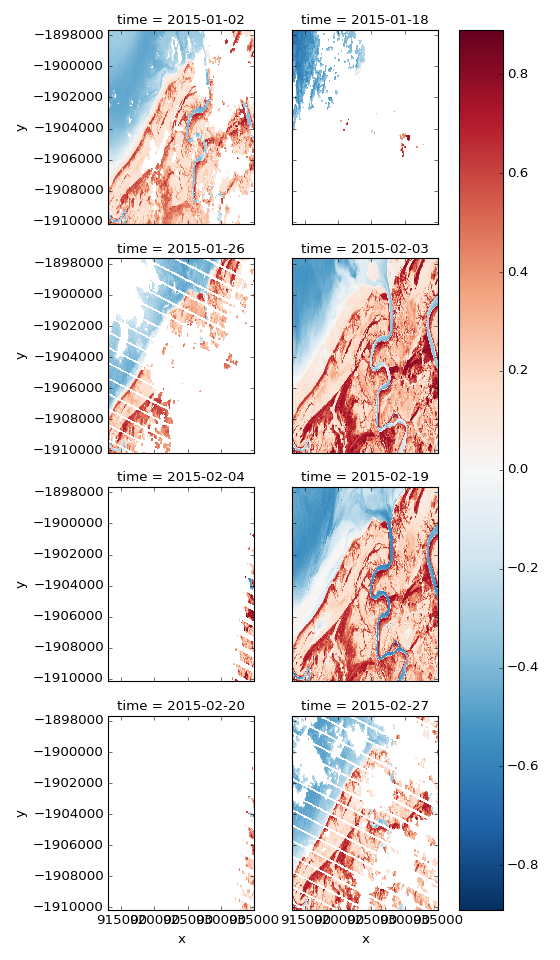

In [17]:
two_monthly_ndvi.plot(col='time', col_wrap=2)

In [18]:
two_monthly_ndvi_mean = two_monthly_ndvi.mean(dim = 'time')
two_monthly_ndvi_mean.shape

(500, 880)

<IPython.core.display.Javascript object>


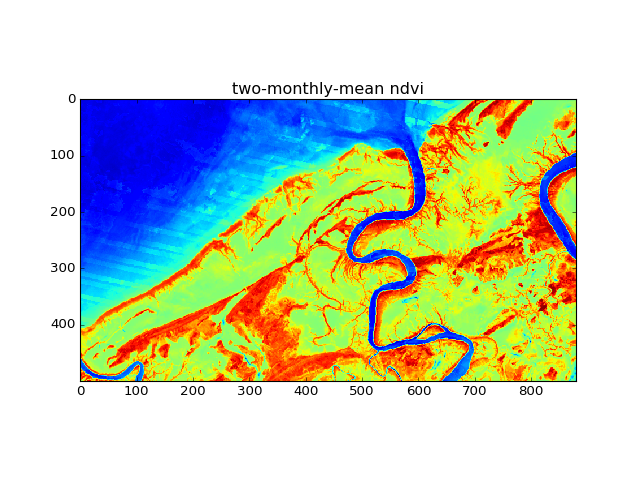

In [19]:
# plot the two-monthly-mean ndvi
fig=plt.figure()
plt.title('two-monthly-mean ndvi')
plt.imshow(two_monthly_ndvi_mean.squeeze(), interpolation = 'nearest')

In [20]:
# calculate two-monthly average NDVI for middle-start of trend
two_monthly_ndvi2 = ndvi.loc['2015-3':'2015-4']
#two_monthly_ndvi2.shape
#two_monthly_ndvi2.plot(col='time', col_wrap=2)

two_monthly_ndvi_mean2 = two_monthly_ndvi2.mean(dim = 'time')
two_monthly_ndvi_mean2.shape

## plot the two-monthly-mean ndvi
#fig=plt.figure()
#plt.title('two-monthly-mean ndvi2')
#plt.imshow(two_monthly_ndvi_mean2.squeeze(), interpolation = 'nearest')

(500, 880)

In [21]:
# calculate two-monthly average NDVI for middle-middle of trend
two_monthly_ndvi3 = ndvi.loc['2015-5':'2015-6']
#two_monthly_ndvi3.shape
#two_monthly_ndvi3.plot(col='time', col_wrap=2)

two_monthly_ndvi_mean3 = two_monthly_ndvi3.mean(dim = 'time')
two_monthly_ndvi_mean3.shape

## plot the two-monthly-mean ndvi
#fig=plt.figure()
#plt.title('two-monthly-mean ndvi3')
#plt.imshow(two_monthly_ndvi_mean3.squeeze(), interpolation = 'nearest')

(500, 880)

In [22]:
# calculate two-monthly average NDVI for middle-end of trend
two_monthly_ndvi4 = ndvi.loc['2015-7':'2015-8']
#two_monthly_ndvi4.shape
#two_monthly_ndvi4.plot(col='time', col_wrap=2)

two_monthly_ndvi_mean4 = two_monthly_ndvi4.mean(dim = 'time')
two_monthly_ndvi_mean4.shape

## plot the two-monthly-mean ndvi
#fig=plt.figure()
#plt.title('two-monthly-mean ndvi4')
#plt.imshow(two_monthly_ndvi_mean4.squeeze(), interpolation = 'nearest')

(500, 880)

In [23]:
# calculate two-monthly average NDVI for nearly-end of trend
two_monthly_ndvi5 = ndvi.loc['2015-9':'2015-10']
#two_monthly_ndvi5.shape
#two_monthly_ndvi5.plot(col='time', col_wrap=2)

two_monthly_ndvi_mean5 = two_monthly_ndvi5.mean(dim = 'time')
two_monthly_ndvi_mean5.shape

## plot the two-monthly-mean ndvi
#fig=plt.figure()
#plt.title('two-monthly-mean ndvi5')
#plt.imshow(two_monthly_ndvi_mean5.squeeze(), interpolation = 'nearest')

(500, 880)

<IPython.core.display.Javascript object>


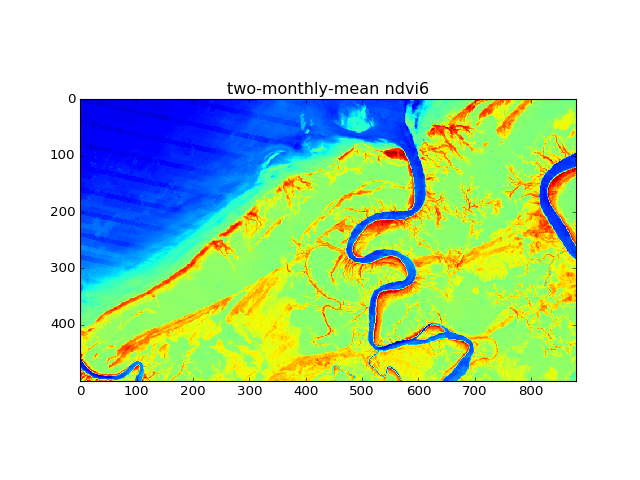

In [25]:
# calculate two-monthly average NDVI for end of trend
two_monthly_ndvi6 = ndvi.loc['2015-11':'2015-12']
#two_monthly_ndvi6.shape
#two_monthly_ndvi6.plot(col='time', col_wrap=2)

two_monthly_ndvi_mean6 = two_monthly_ndvi6.mean(dim = 'time')
two_monthly_ndvi_mean6.shape

## plot the two-monthly-mean ndvi
fig=plt.figure()
plt.title('two-monthly-mean ndvi6')
plt.imshow(two_monthly_ndvi_mean6.squeeze(), interpolation = 'nearest')

<IPython.core.display.Javascript object>


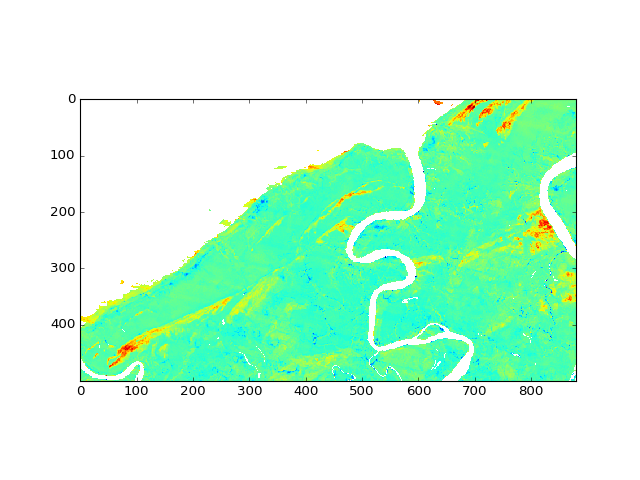

In [28]:
# Calculate two-monthly NDVI difference over trend period

two_monthly_ndvi_change1 = two_monthly_ndvi_mean2 - two_monthly_ndvi_mean
two_monthly_ndvi_change2 = two_monthly_ndvi_mean3 - two_monthly_ndvi_mean2
two_monthly_ndvi_change3 = two_monthly_ndvi_mean4 - two_monthly_ndvi_mean3
two_monthly_ndvi_change4 = two_monthly_ndvi_mean5 - two_monthly_ndvi_mean4
two_monthly_ndvi_change5 = two_monthly_ndvi_mean6 - two_monthly_ndvi_mean5

two_monthly_ndvi_change1_landonly = two_monthly_ndvi_change1.where(two_monthly_ndvi_mean>0)
two_monthly_ndvi_change2_landonly = two_monthly_ndvi_change2.where(two_monthly_ndvi_mean>0)
two_monthly_ndvi_change3_landonly = two_monthly_ndvi_change3.where(two_monthly_ndvi_mean>0)
two_monthly_ndvi_change4_landonly = two_monthly_ndvi_change4.where(two_monthly_ndvi_mean>0)
two_monthly_ndvi_change5_landonly = two_monthly_ndvi_change5.where(two_monthly_ndvi_mean>0)

fig = plt.figure()
#plt.title=('two-monthly-mean difference')
plt.imshow(two_monthly_ndvi_change5_landonly.squeeze(), interpolation = 'nearest')

/g/data2/v10/public/modules/agdc-py2-env/20161201/envs/agdc/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: the `dim` argument to `concat` will be required in a future version of xarray; for now, setting it to the old default of 'concat_dim'
  app.launch_new_instance()


<IPython.core.display.Javascript object>


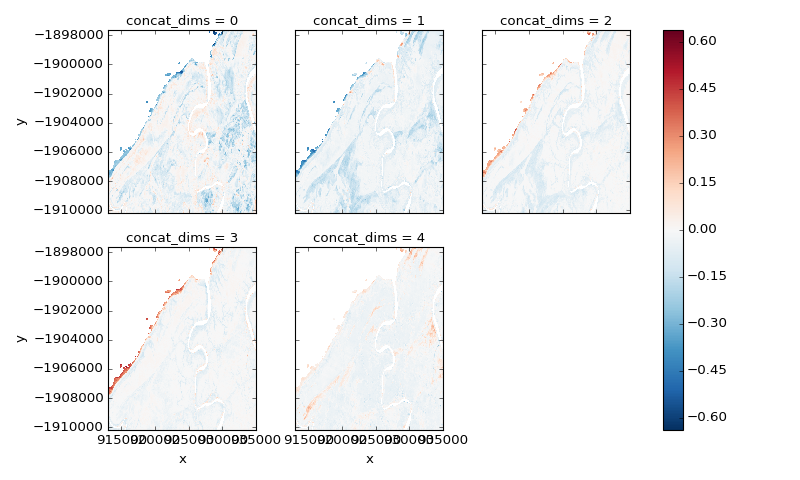

In [29]:
two_monthly_ndvi_change_comb = xr.concat([two_monthly_ndvi_change1_landonly,two_monthly_ndvi_change2_landonly,
                                          two_monthly_ndvi_change3_landonly,two_monthly_ndvi_change4_landonly,
                                         two_monthly_ndvi_change5_landonly])
two_monthly_ndvi_change_comb.shape
#two_monthly_ndvi_change_comb
two_monthly_ndvi_change_comb.plot(col = 'concat_dims', col_wrap=3)

<IPython.core.display.Javascript object>


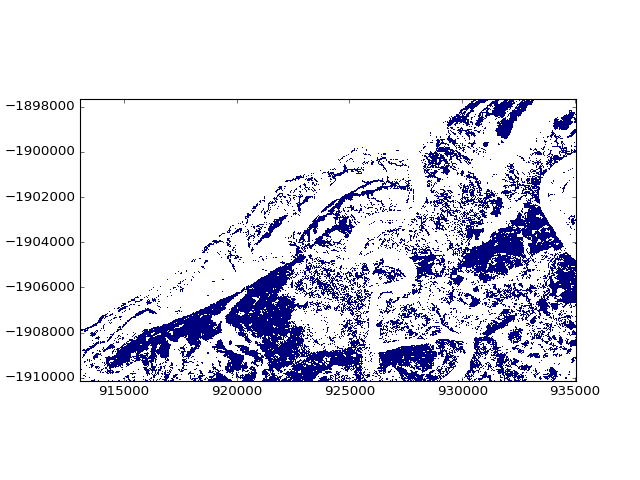

In [45]:
# calculate where ndvi is always reducing over the time periods

two_monthly_ndvi_neg_mask_one = (two_monthly_ndvi_change1_landonly * 0) + 1
#two_monthly_ndvi_neg_mask.shape

two_monthly_ndvi_neg_mask1 = two_monthly_ndvi_neg_mask_one.where(two_monthly_ndvi_change1_landonly<0)
two_monthly_ndvi_neg_mask2 = two_monthly_ndvi_neg_mask_one.where(two_monthly_ndvi_change2_landonly<0)
two_monthly_ndvi_neg_mask3 = two_monthly_ndvi_neg_mask_one.where(two_monthly_ndvi_change3_landonly<0)
two_monthly_ndvi_neg_mask4 = two_monthly_ndvi_neg_mask_one.where(two_monthly_ndvi_change4_landonly<0)
two_monthly_ndvi_neg_mask5 = two_monthly_ndvi_neg_mask_one.where(two_monthly_ndvi_change5_landonly<0)

two_monthly_ndvi_neg_mask = two_monthly_ndvi_neg_mask1 + two_monthly_ndvi_neg_mask2 + two_monthly_ndvi_neg_mask3 + two_monthly_ndvi_neg_mask4
two_monthly_ndvi_neg_mask

# convert the data array into a dataset so netCDF has necessary variable names
nd_dif_ds = two_monthly_ndvi_neg_mask.to_dataset(name = 'ndvi_delta')
# add coordinate reference system (crs) back into the attributes
nd_dif_ds.attrs['crs'] = crs

# write to netCDF file
#write_dataset_to_netcdf(nd_dif_ds,'NDVI_all_neg_diff.nc')

fig = plt.figure()
#plt.title=('two-monthly-mean declining ndvi')
plt.imshow(two_monthly_ndvi_neg_mask.squeeze(), interpolation = 'nearest', 
           extent=[two_monthly_ndvi_neg_mask.coords['x'].min(), two_monthly_ndvi_neg_mask.coords['x'].max(), 
                   two_monthly_ndvi_neg_mask.coords['y'].min(), two_monthly_ndvi_neg_mask.coords['y'].max()])

#Click on image to chose location for time series extraction
w = widgets.HTML("Event information appears here when you click on the figure")
def callback(event):
    global x, y
    x, y = int(event.xdata + 0.5), int(event.ydata + 0.5)
    w.value = 'X: {}, Y: {}'.format(x,y)
    
fig.canvas.mpl_connect('button_press_event', callback)
#plt.title('Change in mean NDVI between '+str(ref_year)+' and '+str(change_year))
plt.show()
display(w)

<IPython.core.display.Javascript object>


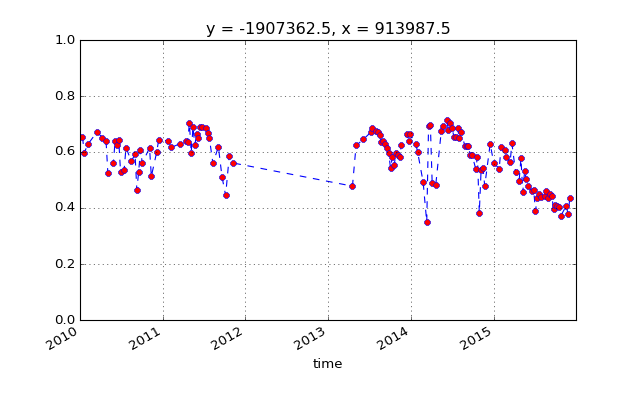

['2010-01-01', '2015-12-31', 0, 1]

In [56]:
# this converts the map x coordinates into image x coordinates
image_coords = ~affine * (x, y)
imagex = int(image_coords[0])
imagey = int(image_coords[1])

#retrieve the time series for the pixel location clicked above
ts_ndvi = ndvi.isel(x=[imagex],y=[imagey]).dropna('time', how = 'any')

# output time-series plot

fig = plt.figure(figsize=(8,5))
plt.show()

firstyear = start_of_epoch
lastyear = end_of_epoch
ts_ndvi.plot(linestyle= '--', c= 'b', marker = '8', mec = 'b', mfc ='r')
plt.grid()   
plt.axis([firstyear, lastyear, 0, 1])

<IPython.core.display.Javascript object>


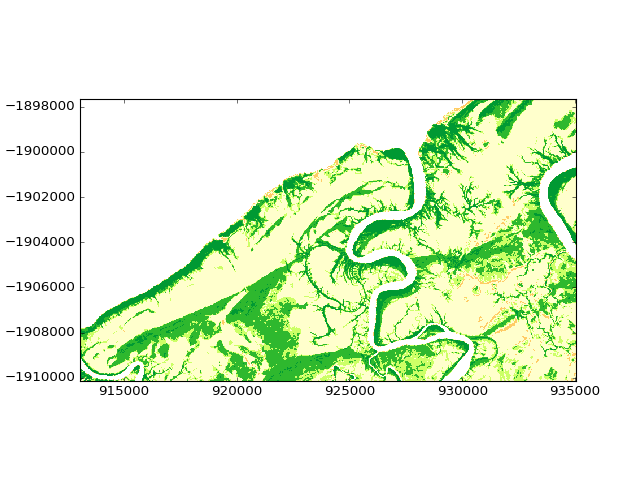

In [33]:
#Plotting image, view transect and select a location to retrieve a time series
fig = plt.figure()
#Plot the mean NDVI values for a year of interest (yoi)
#Dark green = high amounts of green veg with yellow and oranges lower amounts
#Blue indicates NDVI < 0 typically associated with water
yoi = 2014
#plt.title('Average annual NDVI for '+str(yoi))
arr_yoi = annual_mean_landonly.sel(year =yoi)
plt.imshow(arr_yoi.squeeze(), interpolation = 'nearest', cmap = ndvi_cmap, norm = ndvi_norm,
           extent=[arr_yoi.coords['x'].min(), arr_yoi.coords['x'].max(),
                   arr_yoi.coords['y'].min(), arr_yoi.coords['y'].max()])

<IPython.core.display.Javascript object>


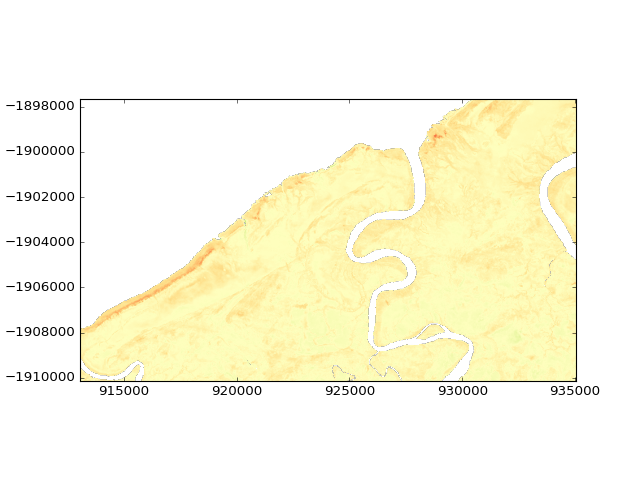

In [34]:
#Calculate the difference between mean NDVI between two years, a reference year and a change year

fig = plt.figure()
#Define year for reference point
ref_year = 2014
#Define year used to detect change
change_year = 2015
nd_ref_year = annual_mean_landonly.sel(year = (ref_year))
nd_change_year = annual_mean_landonly.sel(year = (change_year))
nd_dif = nd_change_year - nd_ref_year
plt.imshow(nd_dif, cmap = 'RdYlGn', vmin = -0.6, vmax = 0.6, 
           extent=[nd_dif.coords['x'].min(), nd_dif.coords['x'].max(), nd_dif.coords['y'].min(), nd_dif.coords['y'].max()])

#Click on image to chose location for time series extraction
w = widgets.HTML("Event information appears here when you click on the figure")
def callback(event):
    global x, y
    x, y = int(event.xdata + 0.5), int(event.ydata + 0.5)
    w.value = 'X: {}, Y: {}'.format(x,y)
    
fig.canvas.mpl_connect('button_press_event', callback)
#plt.title('Change in mean NDVI between '+str(ref_year)+' and '+str(change_year))
plt.show()
display(w)

In [35]:
# This section is for viewing a time series of NDVI and retrieving the image that corresponds with a particular point
# on a time series

# this converts the map x coordinates into image x coordinates
image_coords = ~affine * (x, y)
imagex = int(image_coords[0])
imagey = int(image_coords[1])

#retrieve the time series for the pixel location clicked above and output to csv file
ts_ndvi = ndvi.isel(x=[imagex],y=[imagey]).dropna('time', how = 'any')
#output_name='/g/data2/v10/public/catapult-data/agric_queensland/test_plot.csv'
output_name = '{}_{}_to_{}_{}_{}.csv'.format('_'.join(sensors), start_of_epoch, end_of_epoch, imagex, imagey)
ts_ndvi_ds = ts_ndvi.to_dataframe(name='ts_ndvi_dataset')
ts_ndvi_ds.to_csv(output_name)

<IPython.core.display.Javascript object>


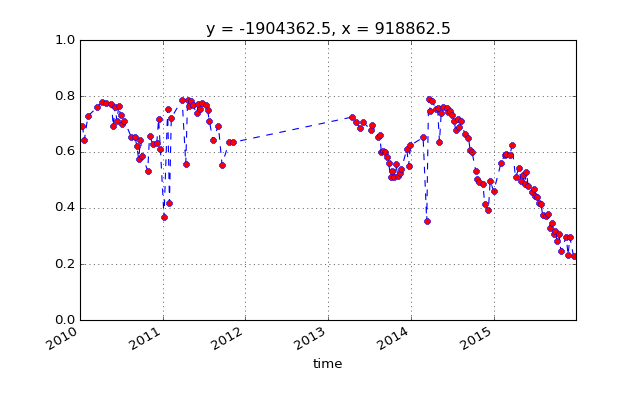

['2010-01-01', '2015-12-31', 0, 1]

In [36]:
#Use this plot to visualise a time series and select the image that corresponds with a point in the time series
def callback(event):
    global time_int, devent
    devent = event
    time_int = event.xdata
    #time_int_ = time_int.astype(datetime64[D])
    w.value = 'time_int: {}'.format(time_int)
    
fig = plt.figure(figsize=(8,5))
fig.canvas.mpl_connect('button_press_event', callback)
plt.show()
display(w)
    
firstyear = start_of_epoch #'2010-01-01'
lastyear = end_of_epoch #'2014-12-31'
ts_ndvi.plot(linestyle= '--', c= 'b', marker = '8', mec = 'b', mfc ='r')
plt.grid()
    
plt.axis([firstyear, lastyear, 0, 1])

In [184]:
##Convert the point clicked in the time series to a date and retrieve the corresponding image

## need to read in swir1 band for this to work
#time_slice = matplotlib.dates.num2date(time_int).date()
#rgb = nbar_clean.sel(time=time_slice, method ='nearest').to_array(dim='color').sel(color=['swir1','nir','green']).transpose('y','x','color')
#fake_saturation = 3000
#clipped_visible = rgb.where(rgb<fake_saturation).fillna(fake_saturation)
#max_val = clipped_visible.max(['y','x'])
#scaled = (clipped_visible / max_val)

In [185]:
##This image shows the time slice of choice and the location of the time series
#fig = plt.figure(figsize=(12,6))
##plt.scatter(x=trans.coords['x'], y=trans.coords['y'], c='r')
#plt.scatter(x = [x], y=[y], c='yellow', marker = 'D')
#plt.imshow(scaled, interpolation = 'nearest',
#          extent=[scaled.coords['x'].min(), scaled.coords['x'].max(),
#                 scaled.coords['y'].min(), scaled.coords['y'].max()])
#plt.title(time_slice)
#plt.show()


In [188]:
# convert the data array into a dataset so netCDF has necessary variable names
nd_dif_ds = nd_dif.to_dataset(name = 'ndvi_delta')
# add coordinate reference system (crs) back into the attributes
nd_dif_ds.attrs['crs'] = crs

In [189]:
# write to netCDF file
write_dataset_to_netcdf(nd_dif_ds,'NDVI_diff_'+str(change_year)+'to'+str(ref_year)+'.nc')